## FOLD-3 MODEL EVALUATION

### Test set Recreation

In [1]:
import torch
import torch.utils.data as data_utils
import h5py
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

from models import cnn_rnn
from utils import test_seq, normalize_mel_sp_slides


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

dataDir = './data'
tempDir = 'temp'

fname = 'birds_xeno_spectr_slide_105_species_sr_32000_len_7_sec_500_250_New.h5'
fileLoc = f"{dataDir}/{fname}"

# Load mel spectrograms
hf = h5py.File(fileLoc, 'r')
mel_sp = hf.get('mel_spectr')[()]
metadata_total = pd.read_hdf(fileLoc, 'info')
hf.close()

# Encode labels
original_label = list(metadata_total['species'])
lb_bin = LabelBinarizer()
lb_enc = LabelEncoder()
labels_one_hot = lb_bin.fit_transform(original_label)
labels_multi_lbl = lb_enc.fit_transform(original_label)

number_of_classes = len(lb_enc.classes_)
print("Number of species:", number_of_classes)

# Normalize mel spectrograms
mel_sp_normalized = []
for i in range(len(mel_sp)):
    xx_ = normalize_mel_sp_slides(mel_sp[i]).astype('float32')
    mel_sp_normalized.append(np.expand_dims(xx_, axis=-3))
mel_sp_normalized = np.array(mel_sp_normalized)


Number of species: 105


In [ ]:
batch_size = 32
hidden_size = 256
cfg_cnn3 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
n_units = 512*2

# Select the RNN config you trained (match with your exp_no / exp_ind)
rnnConfig = {'LSTM_0': {'input_size': n_units, 'h_states_ctr': 2},
             'LSTM_1': {'input_size': hidden_size, 'h_states_ctr': 2}}

skf = StratifiedKFold(n_splits=5, random_state=42)
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(mel_sp_normalized, labels_multi_lbl)):
    if fold_idx == 2:  # pick the third fold
        X_train, X_test_valid = mel_sp_normalized[train_idx], mel_sp_normalized[test_idx]
        y_train, y_test_valid = labels_one_hot[train_idx], labels_one_hot[test_idx]
        y_train_mlbl, y_test_valid_mlbl = labels_multi_lbl[train_idx], labels_multi_lbl[test_idx]
        break

# Split X_test_valid into validation and test (same as training)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test_valid, y_test_valid, test_size=0.5,
    stratify=y_test_valid_mlbl, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# Convert to PyTorch tensors
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_valid = torch.from_numpy(X_valid).float()
y_valid = torch.from_numpy(y_valid).float()

# Train DataLoader
train_dataset = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Test DataLoader
test_dataset = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Valid DataLoader
valid_dataset = data_utils.TensorDataset(X_valid, y_valid)
valid_loader = data_utils.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


### Reloading Model

In [4]:
import torch
from models import cnn_rnn

hidden_size = 256
cfg_cnn3 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'] # CNN3
cfg = {'LSTM_0':{'input_size':1024, 'h_states_ctr':2},
    'LSTM_1':{'input_size':hidden_size, 'h_states_ctr':2}  # 2 layers of LSTM cell
    }
#Recreating Model Architecture
model = cnn_rnn(cnnConfig = cfg_cnn3, 
                        rnnConfig = cfg, 
                        hidden_size=hidden_size, 
                        # order=order,
                        # theta=theta,
                        num_classes=105)


#Filling weights
state_dict = torch.load("./temp/currentModel_cnn_rnn_1_2.pt", map_location="cuda:1")
model.load_state_dict(state_dict)
model = model.to("cuda:1")
model.eval()

cnn_rnn(
  (cnn): cnn(
    (convBlock): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

### Run Evaluation on Test Set

In [5]:
# Prepare hidden state
def prepare_hidden(model, batch_size):
    hidden = model.init_hidden(batch_size)
    return tuple(h.to(device) for h in hidden)

all_train_loss, all_train_acc = test_seq(model, train_loader, device, loss_fn='bceLogit')
all_valid_loss, all_valid_acc = test_seq(model, valid_loader, device, loss_fn='bceLogit')
all_test_loss, all_test_acc = test_seq(model, test_loader, device, loss_fn='bceLogit')

print(f"Train Loss: {all_train_loss:.6f}, Train Accuracy: {all_train_acc:.4f}")

print(f"Validation Loss: {all_valid_loss:.6f}, Validation Accuracy: {all_valid_acc:.4f}")

print(f"Test Loss: {all_test_loss:.6f}, Test Accuracy: {all_test_acc:.4f}")

Train Loss: 0.001071, Train Accuracy: 0.9867
Validation Loss: 0.008926, Validation Accuracy: 0.8754
Test Loss: 0.008995, Test Accuracy: 0.8766


### Other metrics

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
def evaluate_model(model, data_loader, device, top_k=(1, 5)):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            batch_size = X_batch.size(0)
            
            # Prepare hidden state
            hidden = model.init_hidden(batch_size)
            hidden = tuple(h.to(device) for h in hidden)
            
            outputs = model(X_batch, hidden)  # raw logits
            all_preds.append(outputs)
            all_labels.append(y_batch)
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Convert one-hot labels to class indices
    true_classes = torch.argmax(all_labels, dim=1).cpu().numpy()
    pred_classes = torch.argmax(all_preds, dim=1).cpu().numpy()
    
    # Top-k accuracy
    topk_acc = {}
    for k in top_k:
        _, topk_preds = all_preds.topk(k, dim=1)
        topk_preds = topk_preds.cpu().numpy()
        correct = sum([true_classes[i] in topk_preds[i] for i in range(len(true_classes))])
        topk_acc[f"top_{k}"] = correct / len(true_classes)
    
    # Confusion matrix
    cm = confusion_matrix(true_classes, pred_classes)
    
    # Classification report (precision, recall, f1)
    class_report = classification_report(true_classes, pred_classes, output_dict=True)
    
    return pred_classes, true_classes, cm, class_report, topk_acc


In [8]:
pred_classes, true_classes, cm, class_report, topk_acc = evaluate_model(model, test_loader, device)

print(f"Top-1 Accuracy: {topk_acc['top_1']*100:.2f}%")
print(f"Top-5 Accuracy: {topk_acc['top_5']*100:.2f}%")


Top-1 Accuracy: 87.66%
Top-5 Accuracy: 95.73%


### Per-class accuracy, precision, recall, F1

In [9]:
# Example: accuracy per class
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"Class {i} Accuracy: {acc*100:.2f}%")

# Overall precision, recall, f1
precision = np.mean([v['precision'] for k,v in class_report.items() if k.isdigit()])
recall = np.mean([v['recall'] for k,v in class_report.items() if k.isdigit()])
f1 = np.mean([v['f1-score'] for k,v in class_report.items() if k.isdigit()])

print(f"Mean Precision: {precision*100:.2f}%")
print(f"Mean Recall: {recall*100:.2f}%")
print(f"Mean F1-score: {f1*100:.2f}%")


Class 0 Accuracy: 96.00%
Class 1 Accuracy: 96.00%
Class 2 Accuracy: 84.00%
Class 3 Accuracy: 86.00%
Class 4 Accuracy: 94.00%
Class 5 Accuracy: 88.00%
Class 6 Accuracy: 96.00%
Class 7 Accuracy: 84.00%
Class 8 Accuracy: 98.00%
Class 9 Accuracy: 86.00%
Class 10 Accuracy: 92.00%
Class 11 Accuracy: 86.00%
Class 12 Accuracy: 84.00%
Class 13 Accuracy: 88.00%
Class 14 Accuracy: 76.00%
Class 15 Accuracy: 64.00%
Class 16 Accuracy: 82.00%
Class 17 Accuracy: 94.00%
Class 18 Accuracy: 92.00%
Class 19 Accuracy: 84.00%
Class 20 Accuracy: 94.00%
Class 21 Accuracy: 96.00%
Class 22 Accuracy: 94.00%
Class 23 Accuracy: 92.00%
Class 24 Accuracy: 80.00%
Class 25 Accuracy: 84.00%
Class 26 Accuracy: 84.00%
Class 27 Accuracy: 74.00%
Class 28 Accuracy: 96.00%
Class 29 Accuracy: 88.00%
Class 30 Accuracy: 88.00%
Class 31 Accuracy: 78.00%
Class 32 Accuracy: 78.00%
Class 33 Accuracy: 86.00%
Class 34 Accuracy: 86.00%
Class 35 Accuracy: 86.00%
Class 36 Accuracy: 88.00%
Class 37 Accuracy: 92.00%
Class 38 Accuracy: 94.

In [12]:
class_report

{'0': {'precision': 0.9056603773584906,
  'recall': 0.96,
  'f1-score': 0.9320388349514563,
  'support': 50},
 '1': {'precision': 0.9230769230769231,
  'recall': 0.96,
  'f1-score': 0.9411764705882353,
  'support': 50},
 '2': {'precision': 0.8936170212765957,
  'recall': 0.84,
  'f1-score': 0.8659793814432989,
  'support': 50},
 '3': {'precision': 0.8113207547169812,
  'recall': 0.86,
  'f1-score': 0.8349514563106797,
  'support': 50},
 '4': {'precision': 0.8703703703703703,
  'recall': 0.94,
  'f1-score': 0.9038461538461539,
  'support': 50},
 '5': {'precision': 0.9565217391304348,
  'recall': 0.88,
  'f1-score': 0.9166666666666666,
  'support': 50},
 '6': {'precision': 0.9056603773584906,
  'recall': 0.96,
  'f1-score': 0.9320388349514563,
  'support': 50},
 '7': {'precision': 0.8571428571428571,
  'recall': 0.84,
  'f1-score': 0.8484848484848485,
  'support': 50},
 '8': {'precision': 1.0,
  'recall': 0.98,
  'f1-score': 0.98989898989899,
  'support': 50},
 '9': {'precision': 0.84313

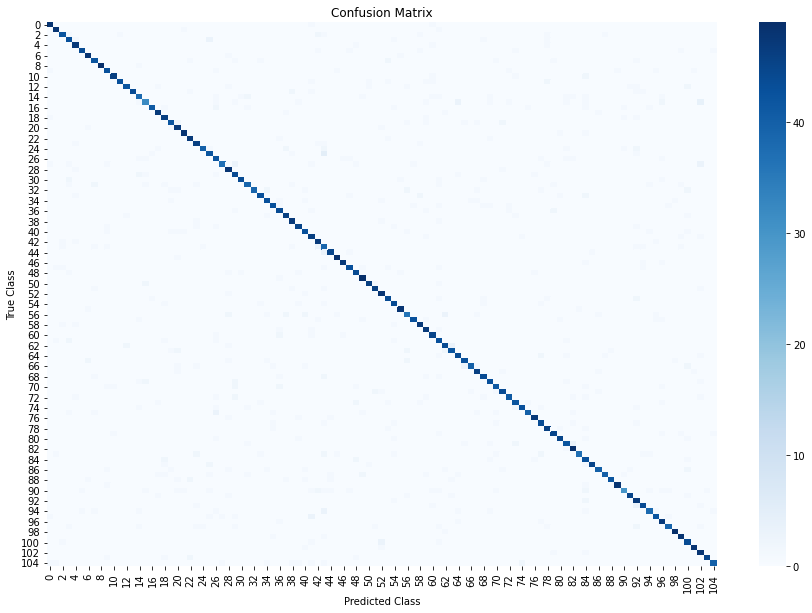

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
